In [1]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install keras_applications


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

                                              0.0/50.7 kB ? eta -:--:--
     --------------------------------         41.0/50.7 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 50.7/50.7 kB 518.8 kB/s eta 0:00:00


# Libraries

In [4]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import MaxPooling2D, concatenate, Convolution2D, Activation
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from keras_applications.imagenet_utils import _obtain_input_shape
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import math
import logging
from tensorflow.keras import layers, models

In [5]:
class ChannelAttention(tf.keras.layers.Layer):
      def __init__(self, filters, ratio):
        super(ChannelAttention, self).__init__()
        self.filters = filters
        self.ratio = ratio

        def build(self, input_shape):
            self.shared_layer_one = tf.keras.layers.Dense(self.filters//self.ratio,
                             activation='relu', kernel_initializer='he_normal', 
                              use_bias=True, 
                              bias_initializer='zeros')
            self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                             kernel_initializer='he_normal',
                             use_bias=True,
                             bias_initializer='zeros')

        def call(self, inputs):
            # AvgPool
            avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
            

            avg_pool = self.shared_layer_one(avg_pool)
            avg_pool = self.shared_layer_two(avg_pool)

            # MaxPool
            max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)
            max_pool = tf.keras.layers.Reshape((1,1,filters))(max_pool)

            max_pool = shared_layer_one(max_pool)
            max_pool = shared_layer_two(max_pool)


            attention = tf.keras.layers.Add()([avg_pool,max_pool])
            attention = tf.keras.layers.Activation('sigmoid')(attention)
            
            return tf.keras.layers.Multiply()([inputs, attention])

In [6]:
class SpatialAttention(tf.keras.layers.Layer):
      def __init__(self, kernel_size):
        super(SpatialAttention, self).__init__()
        self.kernel_size = kernel_size
        
        def build(self, input_shape):
            self.conv2d = tf.keras.layers.Conv2D(filters = 1,
                    kernel_size=self.kernel_size,
                    strides=1,
                    padding='same',
                    activation='sigmoid',
                    kernel_initializer='he_normal',
                    use_bias=False)

        def call(self, inputs):
            
            # AvgPool
            avg_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=3, keepdims=True))(inputs)
            
            # MaxPool
            max_pool = tf.keras.layers.Lambda(lambda x: tf.keras.backend.max(x, axis=3, keepdims=True))(inputs)

            attention = tf.keras.layers.Concatenate(axis=3)([avg_pool, max_pool])

            attention = self.conv2d(attention)


            return tf.keras.layers.multiply([inputs, attention]) 

# Data loading and exploration

In [7]:
IMG_SHAPE  = 227
batch_size = 32
random_seed = 9

In [8]:
fpath = './DataSetClasificado_Recortado'
categories = os.listdir(fpath)
print("List of categories = ",categories,"\n\nNo. of categories = ", len(categories))

List of categories =  ['FASE 0', 'FASE 1', 'FASE 2', 'FASE 3', 'FASE 4', 'FASE 5', 'FASE 6'] 

No. of categories =  7


In [9]:
def load_images_and_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        for image_name in os.listdir(fpath+"/"+category):
            img = cv2.imread(fpath+"/"+category+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_SHAPE, IMG_SHAPE))
            img_array = Image.fromarray(img, 'RGB')

            img_lst.append(np.array(img_array))

            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(categories)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  1120 
No. of labels loaded =  1120
<class 'list'> <class 'list'>


In [10]:
images = np.array(images)
labels = np.array(labels)

print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (1120, 227, 227, 3) 
Labels shape =  (1120,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


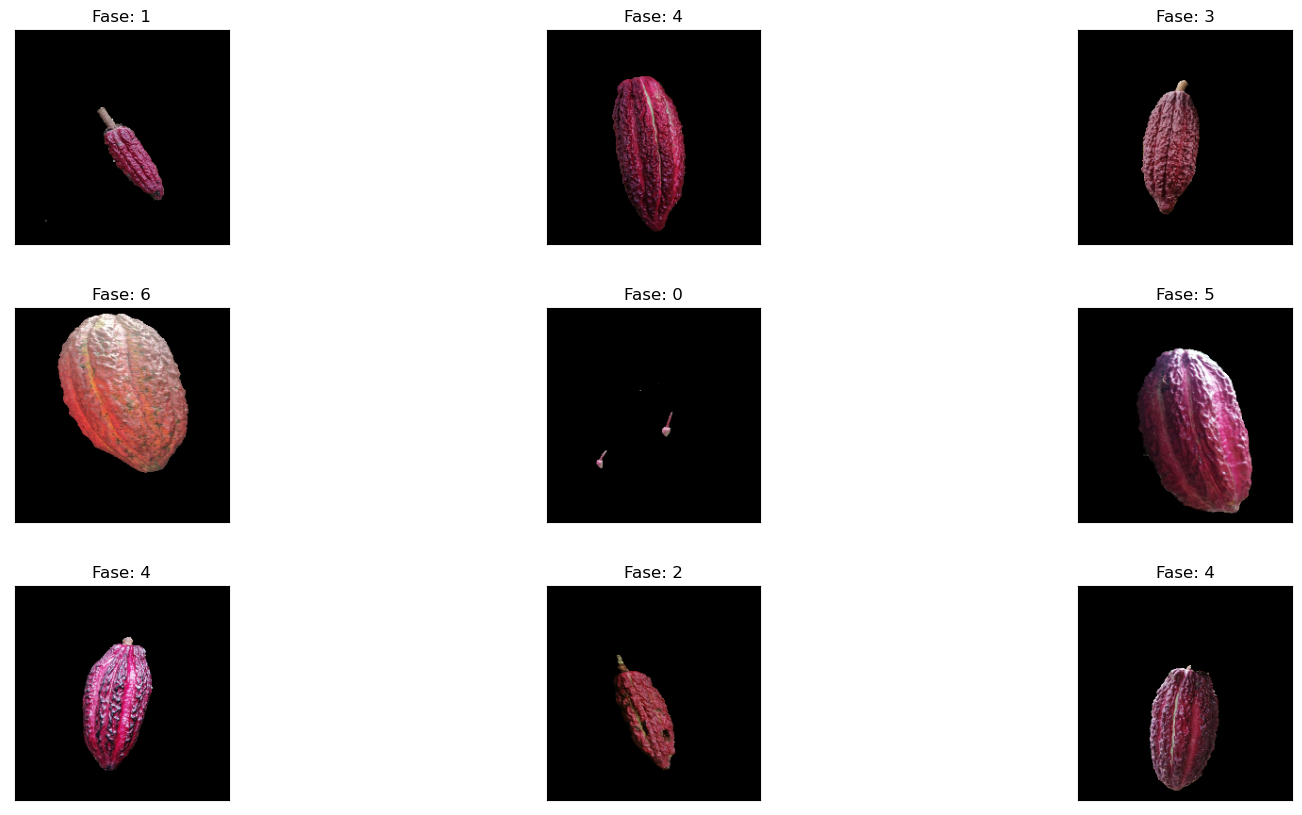

In [12]:
def display_rand_images(images, labels):
    plt.figure(1 , figsize = (19 , 10))
    n = 0 
    for i in range(9):
        n += 1 
        r = np.random.randint(0 , images.shape[0] , 1)
        
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
        plt.imshow(images[r[0]])
        
        plt.title('Fase: {}'.format(labels[r[0]]))
        plt.xticks([])
        plt.yticks([])
        
    plt.show()
    
display_rand_images(images, labels)

# Prepare data for training the CNN model

In [13]:
#1-step in data shuffling

#get equally spaced numbers in a given range
n = np.arange(images.shape[0])
print("'n' values before shuffling = ",n)

#shuffle all the equally spaced values in list 'n'
np.random.seed(random_seed)
np.random.shuffle(n)
print("\n'n' values after shuffling = ",n)

'n' values before shuffling =  [   0    1    2 ... 1117 1118 1119]

'n' values after shuffling =  [ 874 1071  650 ...  638  348  382]


In [14]:
#2-step in data shuffling

#shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape after shuffling = ",images.shape,"\nLabels shape after shuffling = ",labels.shape)

Images shape after shuffling =  (1120, 227, 227, 3) 
Labels shape after shuffling =  (1120,)


In [15]:
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (1120, 227, 227, 3)


In [16]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = random_seed)

x_val = x_train[:58]
y_val = y_train[:58]
x_train = x_train[58:]
y_train = y_train[58:]

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

x_train shape =  (838, 227, 227, 3)
y_train shape =  (838,)

x_test shape =  (224, 227, 227, 3)
y_test shape =  (224,)

x_val shape =  (58, 227, 227, 3)
y_val shape =  (58,)


In [17]:
##One-hot-encode
y_train = to_categorical(y_train, 7)
y_test = to_categorical(y_test, 7)
y_val = to_categorical(y_val, 7)

# Define CNN model

In [19]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

WEIGHTS_PATH = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_NO_TOP = "https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5"

# Modular function for Fire Node

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x


# Original SqueezeNet from paper.

def SqueezeNet(include_top=True, weights='imagenet',
               input_tensor=None, input_shape=None,
               pooling=None,
               classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
        
    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'imagenet' and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `include_top`'
                         ' as true, `classes` should be 1000')


    input_shape = _obtain_input_shape(input_shape,
                                      default_size=227,
                                      min_size=48,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor


    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    if include_top:
        # It's not obvious where to cut the network... 
        # Could do the 8th or 9th layer... some work recommends cutting earlier layers.
    
        x = Dropout(0.5, name='drop9')(x)

        x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
        x = Activation('relu', name='relu_conv10')(x)
        x = GlobalAveragePooling2D()(x)
        x = Activation('sigmoid', name='loss')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling=='max':
            x = GlobalMaxPooling2D()(x)
        elif pooling==None:
            pass
        else:
            raise ValueError("Unknown argument for 'pooling'=" + pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    model = Model(inputs, x, name='squeezenet')

    # load weights
    if weights == 'imagenet':
        if include_top:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('squeezenet_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                    WEIGHTS_PATH_NO_TOP,
                                    cache_subdir='models')
            
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    return model

In [20]:
base_model = SqueezeNet(input_shape=x_train[0].shape, include_top=False, weights="imagenet")

3032184/3032184 [==============================] - 0s 0us/step


In [21]:
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False

input_1
conv1
relu_conv1
pool1
fire2/squeeze1x1
fire2/relu_squeeze1x1
fire2/expand1x1
fire2/expand3x3
fire2/relu_expand1x1
fire2/relu_expand3x3
fire2/concat
fire3/squeeze1x1
fire3/relu_squeeze1x1
fire3/expand1x1
fire3/expand3x3
fire3/relu_expand1x1
fire3/relu_expand3x3
fire3/concat
pool3
fire4/squeeze1x1
fire4/relu_squeeze1x1
fire4/expand1x1
fire4/expand3x3
fire4/relu_expand1x1
fire4/relu_expand3x3
fire4/concat
fire5/squeeze1x1
fire5/relu_squeeze1x1
fire5/expand1x1
fire5/expand3x3
fire5/relu_expand1x1
fire5/relu_expand3x3
fire5/concat
pool5
fire6/squeeze1x1
fire6/relu_squeeze1x1
fire6/expand1x1
fire6/expand3x3
fire6/relu_expand1x1
fire6/relu_expand3x3
fire6/concat
fire7/squeeze1x1
fire7/relu_squeeze1x1
fire7/expand1x1
fire7/expand3x3
fire7/relu_expand1x1
fire7/relu_expand3x3
fire7/concat
fire8/squeeze1x1
fire8/relu_squeeze1x1
fire8/expand1x1
fire8/expand3x3
fire8/relu_expand1x1
fire8/relu_expand3x3
fire8/concat
fire9/squeeze1x1
fire9/relu_squeeze1x1
fire9/expand1x1
fire9/expand3x3
fire

In [28]:
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Conv2D(32, 7, input_shape = x_train[0].shape, activation='elu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, 7, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(32, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 7, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, 7, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    ChannelAttention(64, 8),
    SpatialAttention(7),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, 7, padding='same', activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, 7, padding='same', activation='elu'),
    ChannelAttention(128, 8),
    SpatialAttention(7),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(7, activation='sigmoid' )
])

# Train model

In [29]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 squeezenet (Functional)     (None, 13, 13, 512)       722496    
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 32)        802848    
                                                                 
 batch_normalization_5 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 32)        50208     
                                                                 
 batch_normalization_6 (Batc  (None, 13, 13, 32)       128       
 hNormalization)                                                 
                                                                 
 channel_attention_3 (Channe  (None, 13, 13, 32)      

In [31]:
steps_per_epoch = (x_train.shape[0]//batch_size)
validation_steps = (x_val.shape[0] // batch_size)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [32]:
x_train.shape,y_train.shape

((838, 227, 227, 3), (838, 7))

In [34]:
start_time = time.time()

history = model.fit(x_train, y_train,
    steps_per_epoch=steps_per_epoch,
    epochs = 50,
    validation_data=(x_val, y_val),
    validation_steps=validation_steps,
    batch_size = batch_size,
    callbacks=[es],
    verbose=1)

logging.basicConfig(filename="CNN-basedTL_SqueezeNet_log.txt", level=logging.INFO)
logging.info("Training Execution Time:" + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))

Epoch 1/50
26/26 [==============================] - 17s 649ms/step - loss: 0.3478 - acc: 0.8702 - val_loss: 5.3678 - val_acc: 0.2812
Epoch 2/50
26/26 [==============================] - 16s 623ms/step - loss: 0.4519 - acc: 0.8213 - val_loss: 1.6539 - val_acc: 0.5000
Epoch 3/50
26/26 [==============================] - 16s 604ms/step - loss: 0.3468 - acc: 0.8598 - val_loss: 2.6811 - val_acc: 0.6562
Epoch 4/50
26/26 [==============================] - 16s 607ms/step - loss: 0.3811 - acc: 0.8561 - val_loss: 5.6652 - val_acc: 0.4375
Epoch 5/50
26/26 [==============================] - 16s 608ms/step - loss: 0.4105 - acc: 0.8499 - val_loss: 10.5390 - val_acc: 0.0625
Epoch 6/50
26/26 [==============================] - 16s 608ms/step - loss: 0.4505 - acc: 0.8127 - val_loss: 6.8404 - val_acc: 0.4375
Epoch 7/50
26/26 [==============================] - 16s 606ms/step - loss: 0.3236 - acc: 0.8747 - val_loss: 4.2909 - val_acc: 0.2188
Epoch 8/50
26/26 [==============================] - 16s 610ms/step -

# Evaluation model

In [35]:
start_time = time.time()

loss, accuracy = model.evaluate(x_test,y_test,batch_size=batch_size)
print('test_loss: %.2f' % (loss * 100.0))  
print('test_accuracy: %.2f' % (accuracy * 100.0))

logging.info("Evaluation Execution Time: " + time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
logging.info("test_loss:" + str(loss))
logging.info("test accuracy:" + str(accuracy))

7/7 [==============================] - 2s 326ms/step - loss: 5.8567 - acc: 0.4018
test_loss: 585.67
test_accuracy: 40.18


In [36]:
model_probs = model.predict(x_test,batch_size=batch_size,verbose=0)
y_pred = model_probs
# predict crisp classes for test set
model_classes = np.argmax(model_probs,axis=1)
# reduce to 1d array
model_probs = model_probs[:, 0]

y_test_reduced = np.argmax(y_test,axis=1)
 
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test_reduced, model_classes)*100
# precision tp / (tp + fp)
precision = precision_score(y_test_reduced, model_classes, average='weighted')*100
# recall: tp / (tp + fn)
recall = recall_score(y_test_reduced, model_classes, average='weighted')*100
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test_reduced, model_classes, average='weighted')*100

print('Accuracy: %.2f' % accuracy)
print('F1 score: %.2f' % f1)
print('Precision: %.2f' % precision)
print('Recall: %.2f' % recall)

logging.info('Accuracy: %.2f' % accuracy)
logging.info('F1 score: %.2f' % f1)
logging.info('Precision: %.2f' % precision)
logging.info('Recall: %.2f' % recall)

Accuracy: 32.59
F1 score: 26.09
Precision: 42.91
Recall: 32.59


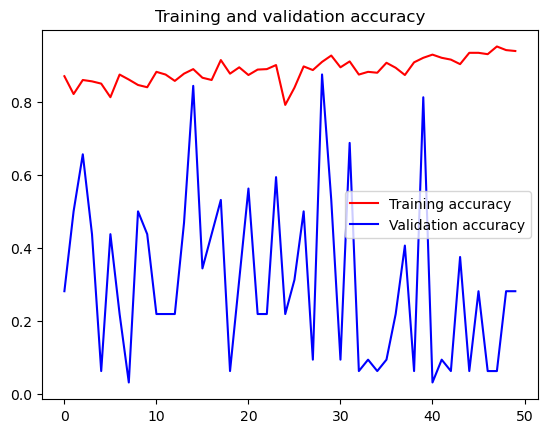

In [37]:
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, validation_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.savefig("Training and validation accuracy - SqueezeNet_AttentionModules.png")
plt.show() 

In [38]:
y_pred = model.predict(x_test)

7/7 [==============================] - 2s 317ms/step


In [39]:
Y_pred_classes = np.argmax(y_pred,axis = 1) 

In [40]:
Y_test_classes = np.argmax(y_test,axis = 1) 

In [41]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(Y_test_classes,Y_pred_classes)
print('Confusion Matrix\n')
print(confusion) 

Confusion Matrix

[[28  1  0  0  0  0  0]
 [11 28  0  0  0  0  0]
 [ 0 37  0  0  0  0  0]
 [ 0 22  0 11  0  0  0]
 [ 0  5  3 11  1  0  0]
 [ 0  0  0 27  1  2  0]
 [ 0  7 15  8  0  3  3]]


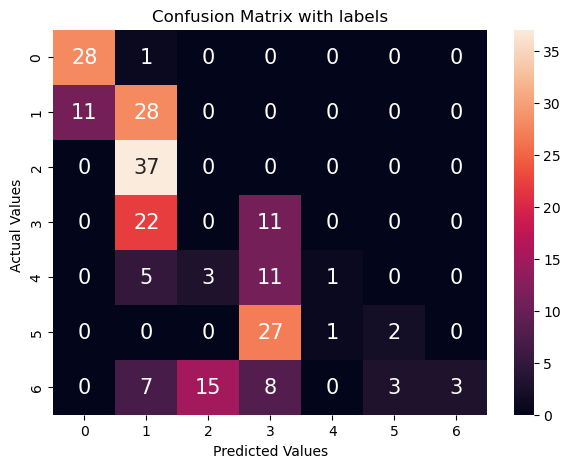

In [42]:
import seaborn as sns
plt.figure(figsize=(7, 5))
plt.xlabel("Preciccion")
plt.ylabel("Actual")
gf = sns.heatmap(confusion, annot=True,  annot_kws={'size': 15}, fmt = "d")
gf.set_title('Confusion Matrix with labels')
gf.set_xlabel('Predicted Values')
gf.set_ylabel('Actual Values ')
plt.show()